In [169]:
%matplotlib inline
%config IPCompleter.greedy=True

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

from keras.utils import Sequence
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

import warnings
warnings.filterwarnings('ignore')

In [143]:
# Each image is 28 pixels in height and 28 pixels in width
# total of 784 pixels

In [144]:
test = pd.read_csv("../../data/digitrecognizer/test.csv")
train = pd.read_csv("../../data/digitrecognizer/train.csv")

# test = pd.read_csv("../input/digit-recognizer/test.csv")
# train = pd.read_csv("../input/digit-recognizer/train.csv")

In [145]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


(None, None)

In [146]:
# split label and feature data
train_labels = (train['label'])
train_features = (train.iloc[:, 1:].values).astype('float32')
test_features = (test.values).astype('int32')

In [147]:
# reshape into pixel dimensions and 1 column for gray scale
train_features = train_features.reshape(train_features.shape[0], 28, 28, 1)
test_features = test_features.reshape(test_features.shape[0], 28, 28, 1)
train_features.shape, test_features.shape, train_labels.shape

((42000, 28, 28, 1), (28000, 28, 28, 1), (42000,))

In [148]:
# display sample digits 
for i in range(16, 7):
    plt.subplot(330 + (i+1))
    plt.imshow(train_features[i], cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i]);

plt.show()

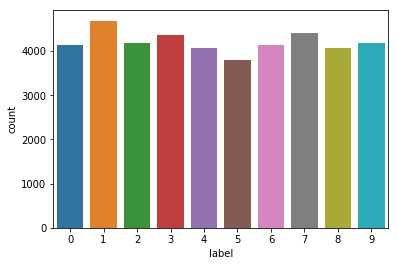

In [149]:
g = sns.countplot(train_labels)

In [150]:
# normalisation of the data so its between 0 and 1
train_features = train_features.astype('float32')/255.
test_features = test_features.astype('float32')/255.

In [151]:
# convert the target labels to categorical 
train_labels = to_categorical(train_labels)
train_features.shape, train_labels.shape

((42000, 28, 28, 1), (42000, 10))

In [152]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.10, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

In [153]:
# setup the basic CNN
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), 
                    activation='relu', 
                    kernel_initializer='he_normal',
                    input_shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
          
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [154]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4),metrics=['accuracy'])

In [155]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 5, 64)         

In [1]:
# Model Parameters with learning rate scheduler
batchsize = 32
num_classes = 10
epochs = 40
stepsperepoch = X_train.shape[0]// batchsize
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

NameError: name 'X_train' is not defined

In [182]:
# Data augmentation for the images
# datagen = ImageDataGenerator(
#                     rotation_range=25,  
#                     zoom_range = 0.10,  
#                     width_shift_range=0.2, 
#                     height_shift_range=0.2)
from keras.utils import Sequence
datagen = ImageDataGenerator(rotation_range=10,
                                zoom_range = 0.2,  
                                width_shift_range=0.1, 
                                height_shift_range=0.1,
                                zca_whitening=True,
                                featurewise_center=True, 
                                featurewise_std_normalization=True)

train_batches = datagen.flow(X_train, y_train, batch_size=batchsize)

In [ ]:
# fit the model 
history = model.fit_generator(generator=train_batches, 
                    steps_per_epoch = stepsperepoch,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[annealer])

Train for 590 steps, validate on 4200 samples
Epoch 1/40
590/590 [==============================] - 9s 15ms/step - loss: 0.0827 - accuracy: 0.9777 - val_loss: 0.0313 - val_accuracy: 0.9905
Epoch 2/40
590/590 [==============================] - 8s 14ms/step - loss: 0.0705 - accuracy: 0.9802 - val_loss: 0.0213 - val_accuracy: 0.9931
Epoch 3/40
304/590 [==============>...............] - ETA: 3s - loss: 0.0671 - accuracy: 0.9806

In [178]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
history_dict = history.history

Training Accuracy: 0.9901
Testing Accuracy:  0.9902


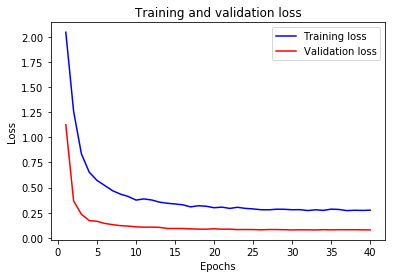

In [168]:
# Plot Loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='b', label='Training loss')
plt.plot(epochs, val_loss, color='r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

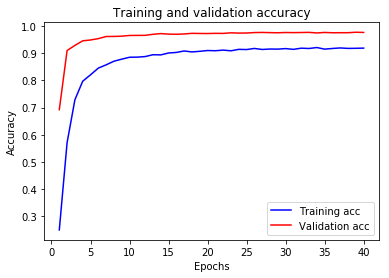

In [164]:
# Plot Accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.clf() 
plt.plot(epochs, acc, color='b', label='Training acc')
plt.plot(epochs, val_acc, color='r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Run predictions

In [162]:
predict = model.predict_classes(test_features, verbose=0)
predict.shape

(28000,)

In [ ]:
result=pd.DataFrame({'ImageId': list(range(1,len(predict)+1)),
                         'Label': predict})

In [ ]:
result.to_csv('DSKsubmission.csv', index=False)

In [ ]:
result